In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, BatchNormalization, Dropout, RepeatVector, TimeDistributed, concatenate
from tensorflow.keras.optimizers import Adam
from scipy import stats
from sklearn.model_selection import train_test_split

In [34]:
VehicleDF = pd.read_excel('Dataset.xlsx', sheet_name='Trip')
ChargingDF = pd.read_excel('Dataset.xlsx', sheet_name='Charge Cycle')

### Preprocessing

In [35]:
ChargingDF['Local Charge Start Time'] = pd.to_datetime(ChargingDF['Local Charge Start Time'],
                                                       format='mixed')
ChargingDF['Local Charge End Time'] = pd.to_datetime(ChargingDF['Local Charge End Time'],
                                                     format='mixed')
VehicleDF['Local Trip Start Time'] = pd.to_datetime(VehicleDF['Local Trip Start Time'],
                                                    format='mixed')
VehicleDF['Local Trip End Time'] = pd.to_datetime(VehicleDF['Local Trip End Time'],
                                                  format='mixed')

In [36]:
characteristics = pd.concat([ChargingDF.isnull().sum(), 
                             ChargingDF.notnull().sum(), 
                             ChargingDF.nunique(), 
                             ChargingDF.dtypes],
                        keys=['Null Values', 
                              'Available Values', 
                              'Unique Values', 
                              'Data Types'],
                        axis=1)
characteristics

,Null Values,Available Values,Unique Values,Data Types
Vehicle ID,0,6296,8,object
Local Charge Start Time,0,6296,6274,datetime64[ns]
Local Charge End Time,0,6296,6265,datetime64[ns]
Starting SOC,0,6296,170,float64
Ending SOC,0,6296,120,float64
Total Energy Delivered,0,6296,5705,float64
Average Power,0,6296,6210,float64
Max Power,0,6296,4371,float64


In [37]:
characteristics = pd.concat([VehicleDF.isnull().sum(), 
                             VehicleDF.notnull().sum(), 
                             VehicleDF.nunique(), 
                             VehicleDF.dtypes],
                        keys=['Null Values', 
                              'Available Values', 
                              'Unique Values', 
                              'Data Types'],
                        axis=1)
characteristics

,Null Values,Available Values,Unique Values,Data Types
Vehicle ID,0,8013,27,object
Local Trip Start Time,0,8013,7893,datetime64[ns]
Local Trip End Time,0,8013,7931,datetime64[ns]
Initial SOC,0,8013,3161,float64
Final SOC,0,8013,3257,float64
SOC Used,0,8013,3271,float64
Total Energy Consumption,0,8013,7850,float64
Total Distance,0,8013,5465,float64
Average Ambient Temperature,0,8013,4849,float64


In [38]:
ChargingDF['Charging Duration (Hours)'] = round((
    ChargingDF['Local Charge End Time'] - ChargingDF['Local Charge Start Time']
    ).dt.total_seconds() / 3600, 2)
ChargingDF['Total SOC Charged'] = (
    ChargingDF['Ending SOC'] - ChargingDF['Starting SOC']
    )
ChargingDF.head(5)

,Vehicle ID,Local Charge Start Time,Local Charge End Time,Starting SOC,Ending SOC,Total Energy Delivered,Average Power,Max Power,Charging Duration (Hours),Total SOC Charged
0,EV026,2017-09-01 08:05:00,2017-09-01 08:09:00,81.0,99.5,13.910,193.386,342.28,0.07,18.5
1,EV026,2017-09-01 09:02:00,2017-09-01 09:11:00,65.0,100.0,24.091,308.800,363.64,0.15,35.0
2,EV026,2017-09-01 10:08:00,2017-09-01 10:14:00,57.5,100.0,31.054,327.830,364.82,0.10,42.5
3,EV026,2017-09-01 11:05:00,2017-09-01 11:14:00,62.5,99.5,25.935,321.533,361.06,0.15,37.0
4,EV026,2017-09-01 12:10:00,2017-09-01 12:19:00,56.5,100.0,32.010,230.942,360.10,0.15,43.5


In [39]:
VehicleDF['Energy Efficiency'] = np.where(VehicleDF['Total Distance'] == 0, 
                                          np.nan, 
                                          round(VehicleDF['SOC Used'] 
                                                / VehicleDF['Total Distance'], 2))
VehicleDF['Trip Duration (Hours)'] = (
    VehicleDF['Local Trip End Time'] - VehicleDF['Local Trip Start Time']
    ).dt.total_seconds() / 3600
VehicleDF = round(VehicleDF,3)

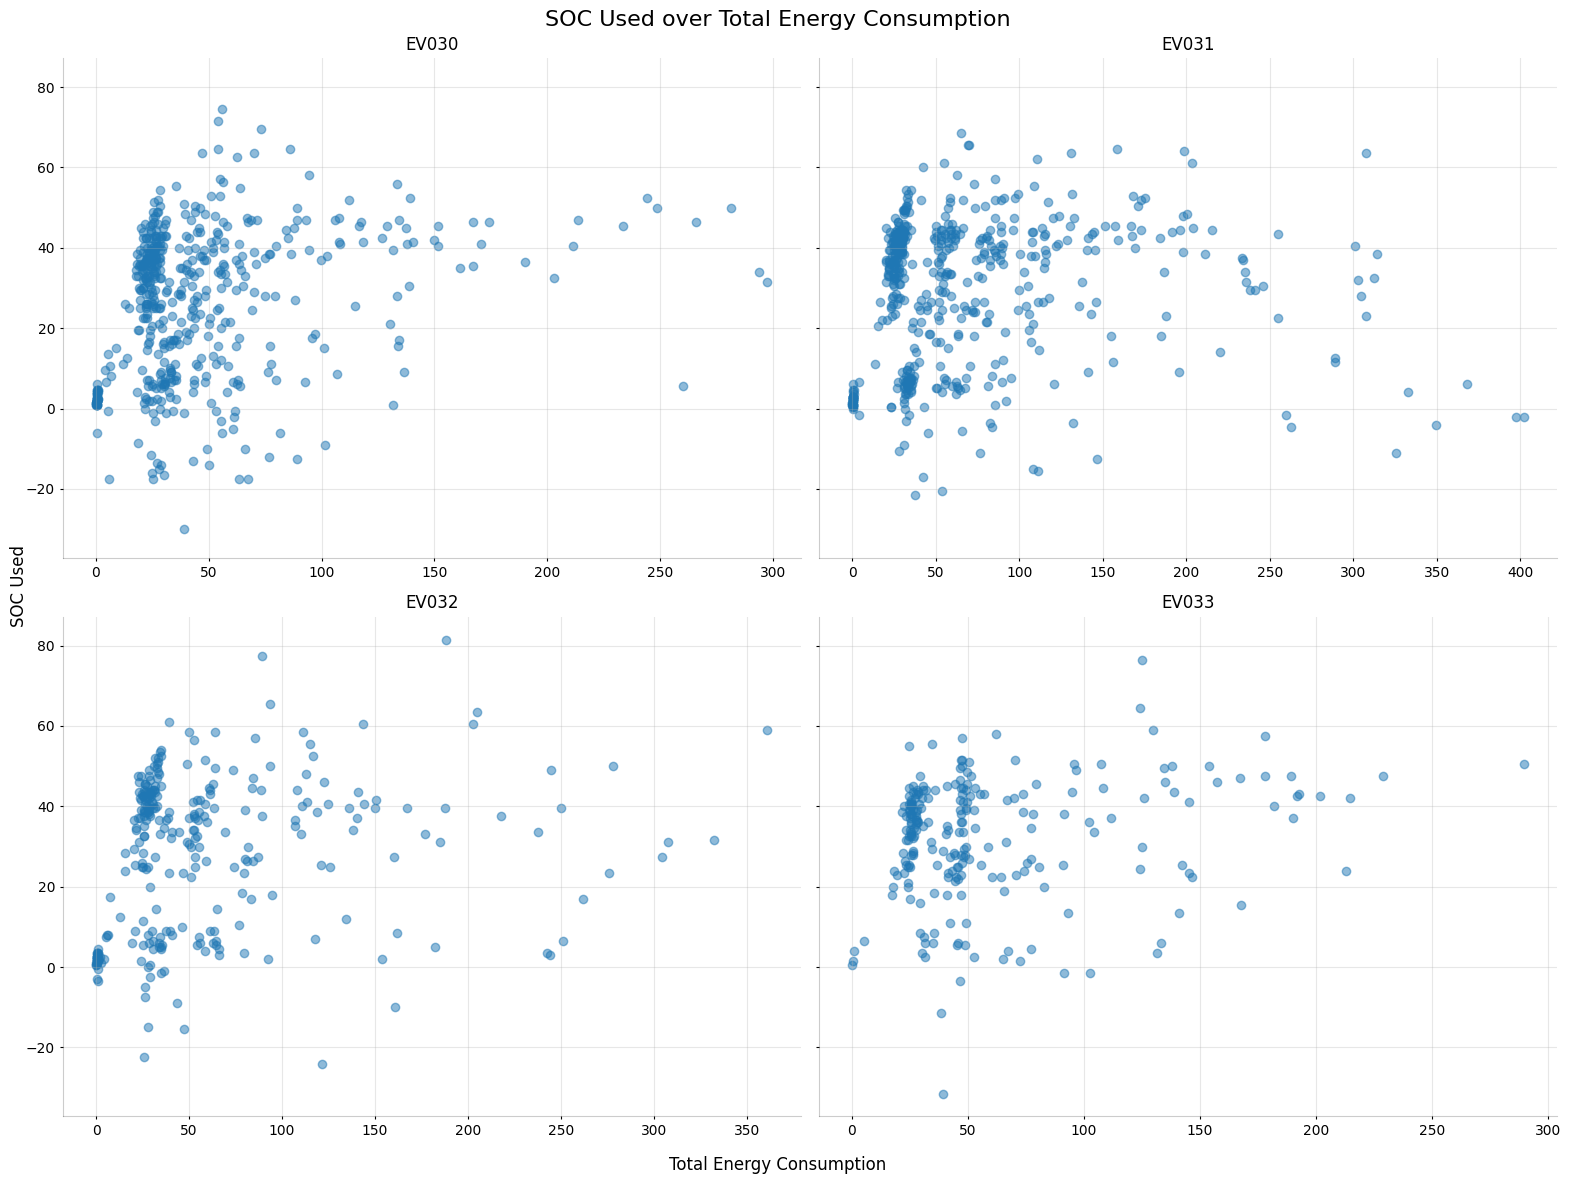

In [95]:
VehicleID = VehicleDF['Vehicle ID'].unique()[4:8]

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes = axes.flatten()

for i, VehicleID in enumerate(VehicleID):
    VehicleDFPlot = VehicleDF[VehicleDF['Vehicle ID'] == VehicleID] \
        .sort_values(by='Total Energy Consumption')
    ax = axes[i]
    ax.scatter(VehicleDFPlot['Total Energy Consumption'],
         VehicleDFPlot['SOC Used'],
         marker='o',
         label=f'Vehicles {VehicleID}',
         alpha=0.5)
    ax.set_title(f'{VehicleID}')
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color((0, 0, 0, 0.2))
    ax.spines['bottom'].set_color((0, 0, 0, 0.2))

    ax.tick_params(axis='both', which='both', length=2)


fig.suptitle('SOC Used over Total Energy Consumption', fontsize='16')
fig.supxlabel('Total Energy Consumption')
fig.supylabel('SOC Used')
plt.tight_layout()
plt.show()

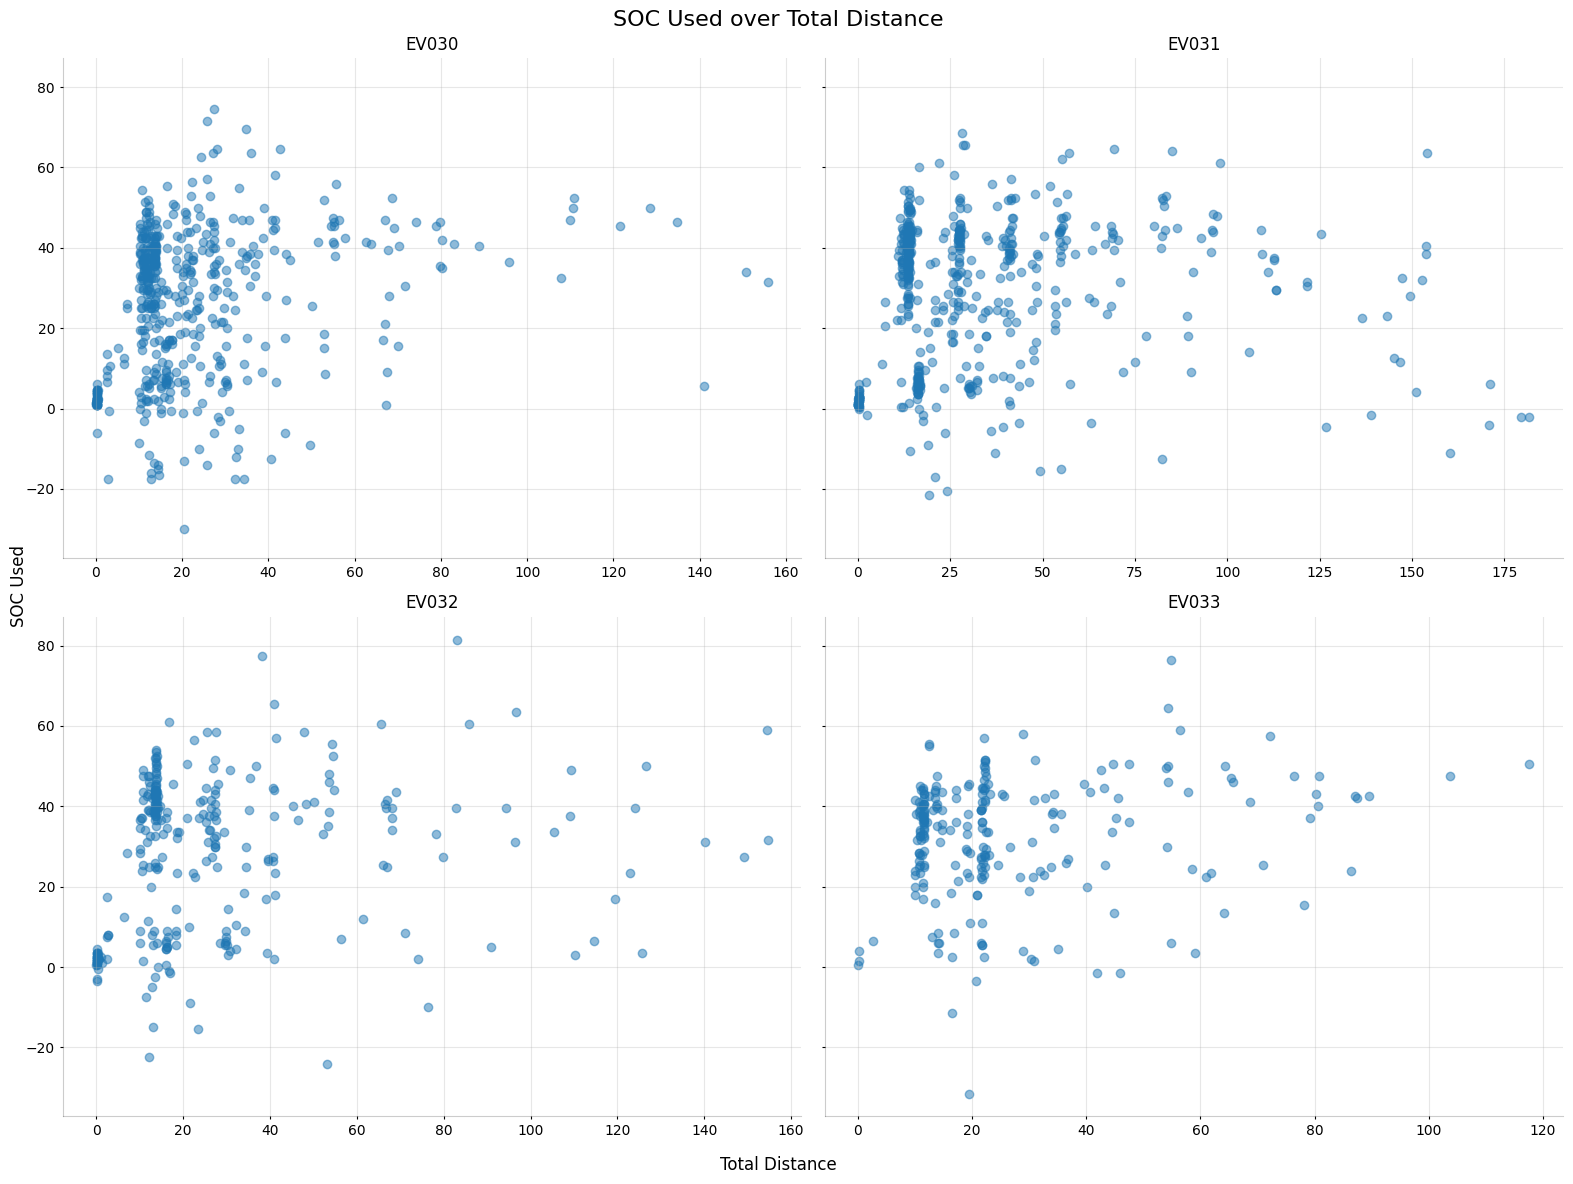

In [96]:
VehicleID = VehicleDF['Vehicle ID'].unique()[4:8]

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes = axes.flatten()

for i, VehicleID in enumerate(VehicleID):
    VehicleDFPlot = VehicleDF[VehicleDF['Vehicle ID'] == VehicleID] \
        .sort_values(by='Total Distance')
    ax = axes[i]
    ax.scatter(VehicleDFPlot['Total Distance'],
         VehicleDFPlot['SOC Used'],
         marker='o',
         label=f'Vehicles {VehicleID}',
         alpha=0.5)
    ax.set_title(f'{VehicleID}')
    ax.grid(True, alpha=0.3)
    if i >= 4:
        ax.set_label('Local Trip End Time')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color((0, 0, 0, 0.2))
    ax.spines['bottom'].set_color((0, 0, 0, 0.2))

    ax.tick_params(axis='both', which='both', length=2)


fig.suptitle('SOC Used over Total Distance', fontsize='16')
fig.supxlabel('Total Distance')
fig.supylabel('SOC Used')
plt.tight_layout()
plt.show()

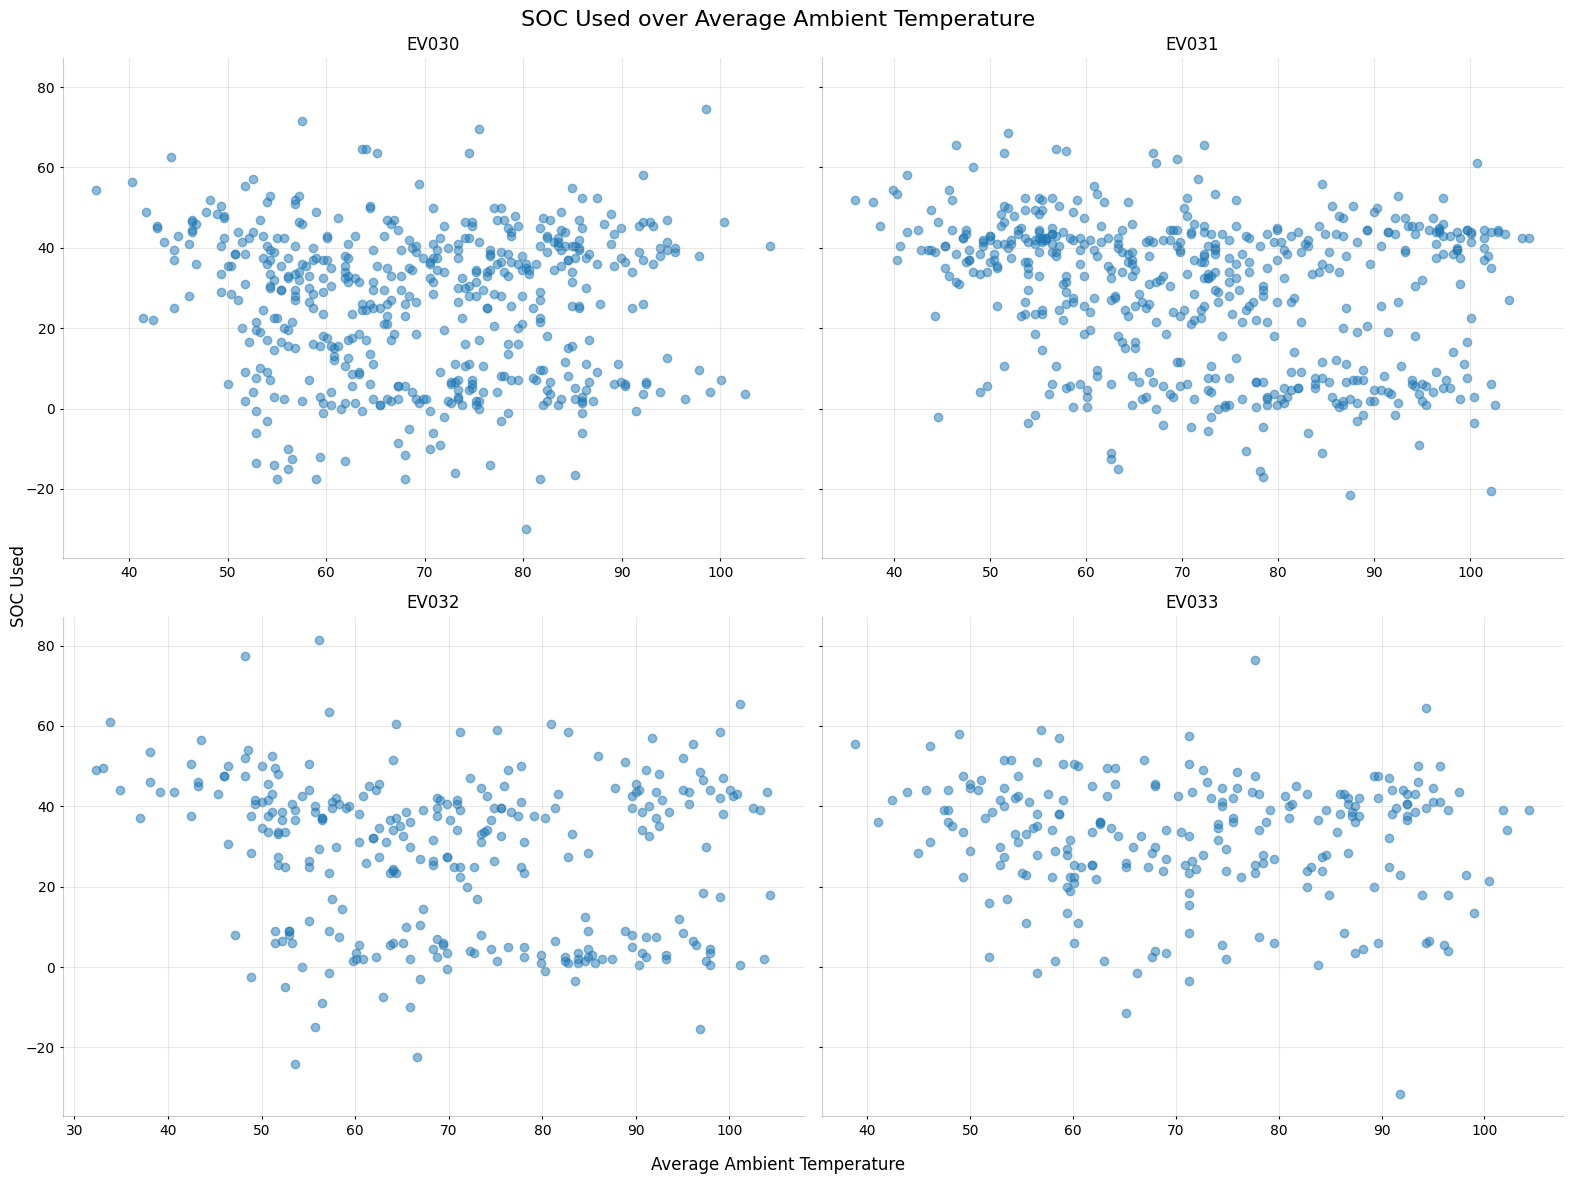

In [98]:
VehicleID = VehicleDF['Vehicle ID'].unique()[4:8]

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes = axes.flatten()

for i, VehicleID in enumerate(VehicleID):
    VehicleDFPlot = VehicleDF[VehicleDF['Vehicle ID'] == VehicleID] \
        .sort_values(by='Average Ambient Temperature')
    ax = axes[i]
    ax.scatter(VehicleDFPlot['Average Ambient Temperature'],
         VehicleDFPlot['SOC Used'],
         marker='o',
         label=f'Vehicles {VehicleID}',
         alpha=0.5)
    ax.set_title(f'{VehicleID}')
    ax.grid(True, alpha=0.3)
    if i >= 4:
        ax.set_label('Local Trip End Time')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color((0, 0, 0, 0.2))
    ax.spines['bottom'].set_color((0, 0, 0, 0.2))

    ax.tick_params(axis='both', which='both', length=2)


fig.suptitle('SOC Used over Average Ambient Temperature', fontsize='16')
fig.supxlabel('Average Ambient Temperature')
fig.supylabel('SOC Used')
plt.tight_layout()
plt.show()

In [8]:
VehicleDF = VehicleDF.drop(labels=['Local Trip Start Time'], axis=1)

In [9]:
VehicleDF = VehicleDF[VehicleDF['Trip Duration (Hours)'] >= 0]

In [10]:
VehicleDF.sort_values(by=['Vehicle ID', 'Local Trip End Time'], inplace=True)

In [11]:
round(VehicleDF.describe(), 2)

,Local Trip End Time,Initial SOC,Final SOC,SOC Used,Total Energy Consumption,Total Distance,Average Ambient Temperature,Energy Efficiency,Trip Duration (Hours)
count,8009,8009.00,8009.00,8009.00,8009.00,8009.00,8009.00,6876.00,8009.00
mean,2021-01-30 06:59:43.630915328,86.39,76.10,18.17,55.58,22.43,70.20,3.16,3.23
min,2018-01-02 07:21:00,0.00,0.00,-40.50,0.00,0.00,7.25,-44.81,0.02
25%,2018-07-31 08:25:00,80.50,59.32,0.33,1.32,0.15,61.52,0.54,0.40
50%,2022-08-04 15:20:00,93.00,81.09,5.23,23.42,11.44,71.26,0.95,1.23
75%,2022-11-23 10:48:00,98.91,93.57,35.00,70.28,31.01,79.16,2.85,3.85
max,2023-03-27 23:59:00,100.00,100.00,187.87,801.24,181.77,108.68,425.81,24.15
std,NaN,17.23,20.10,23.24,85.05,32.81,14.17,10.04,4.61


In [12]:
ChargingDF.head(5)

,Vehicle ID,Local Charge Start Time,Local Charge End Time,Starting SOC,Ending SOC,Total Energy Delivered,Average Power,Max Power,Charging Duration (Hours),Total SOC Charged
0,EV026,2017-09-01 08:05:00,2017-09-01 08:09:00,81.0,99.5,13.910,193.386,342.28,0.07,18.5
1,EV026,2017-09-01 09:02:00,2017-09-01 09:11:00,65.0,100.0,24.091,308.800,363.64,0.15,35.0
2,EV026,2017-09-01 10:08:00,2017-09-01 10:14:00,57.5,100.0,31.054,327.830,364.82,0.10,42.5
3,EV026,2017-09-01 11:05:00,2017-09-01 11:14:00,62.5,99.5,25.935,321.533,361.06,0.15,37.0
4,EV026,2017-09-01 12:10:00,2017-09-01 12:19:00,56.5,100.0,32.010,230.942,360.10,0.15,43.5


In [13]:
ChargingDF.drop('Local Charge Start Time', axis=1, inplace=True)

In [14]:
ChargingDF.sort_values(by=['Local Charge End Time', 'Vehicle ID'], inplace=True)

In [15]:
ChargingDF.head(5)

,Vehicle ID,Local Charge End Time,Starting SOC,Ending SOC,Total Energy Delivered,Average Power,Max Power,Charging Duration (Hours),Total SOC Charged
0,EV026,2017-09-01 08:09:00,81.0,99.5,13.910,193.386,342.28,0.07,18.5
1,EV026,2017-09-01 09:11:00,65.0,100.0,24.091,308.800,363.64,0.15,35.0
2,EV026,2017-09-01 10:14:00,57.5,100.0,31.054,327.830,364.82,0.10,42.5
3,EV026,2017-09-01 11:14:00,62.5,99.5,25.935,321.533,361.06,0.15,37.0
4,EV026,2017-09-01 12:19:00,56.5,100.0,32.010,230.942,360.10,0.15,43.5


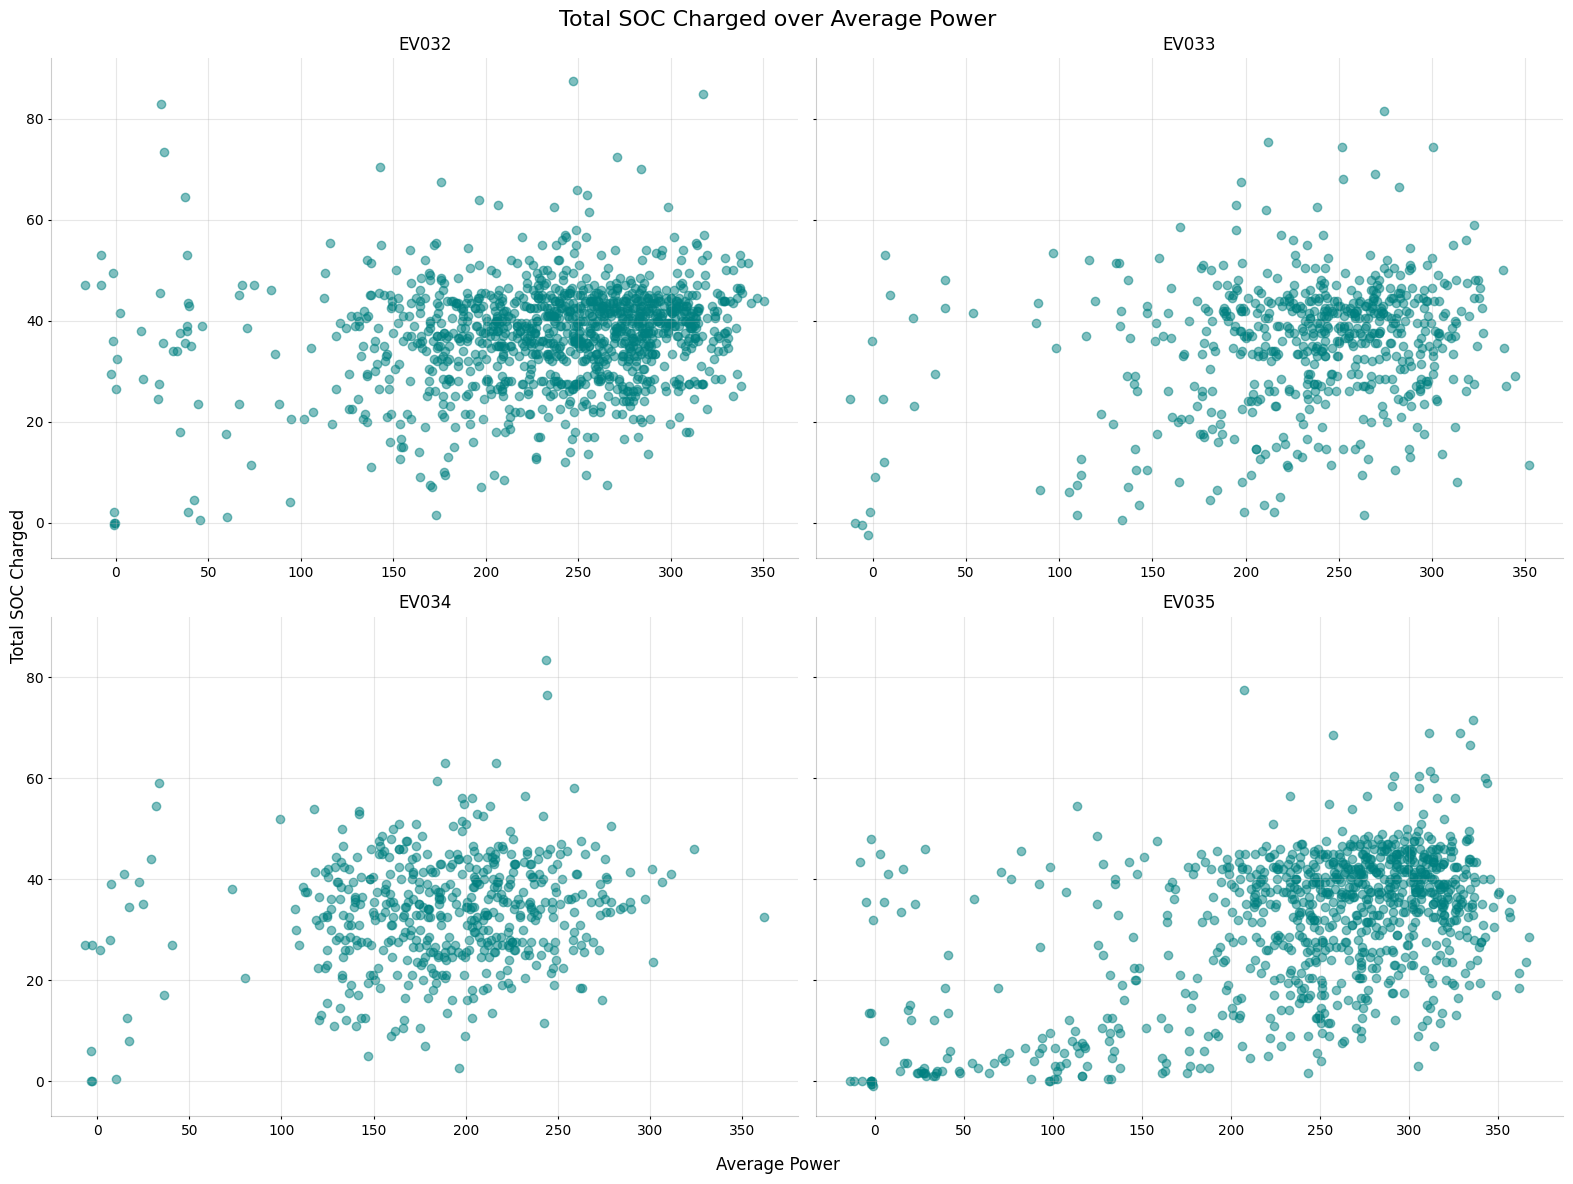

In [104]:
VehicleID = ChargingDF['Vehicle ID'].unique()[4:8]

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes = axes.flatten()

for i, VehicleID in enumerate(VehicleID):
    ChargingDFPlot = ChargingDF[ChargingDF['Vehicle ID'] == VehicleID] \
        .sort_values(by='Average Power')
    ax = axes[i]
    ax.scatter(ChargingDFPlot['Average Power'],
         ChargingDFPlot['Total SOC Charged'],
         color='teal',
         label=f'Vehicles {VehicleID}',
         alpha=0.5)
    ax.set_title(f'{VehicleID}')
    ax.grid(True, alpha=0.3)
    if i >= 4:
        ax.set_label('Local Trip End Time')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color((0, 0, 0, 0.2))
    ax.spines['bottom'].set_color((0, 0, 0, 0.2))

    ax.tick_params(axis='both', which='both', length=2)


fig.suptitle('Total SOC Charged over Average Power', fontsize='16')
fig.supxlabel('Average Power')
fig.supylabel('Total SOC Charged')
plt.tight_layout()
plt.show()

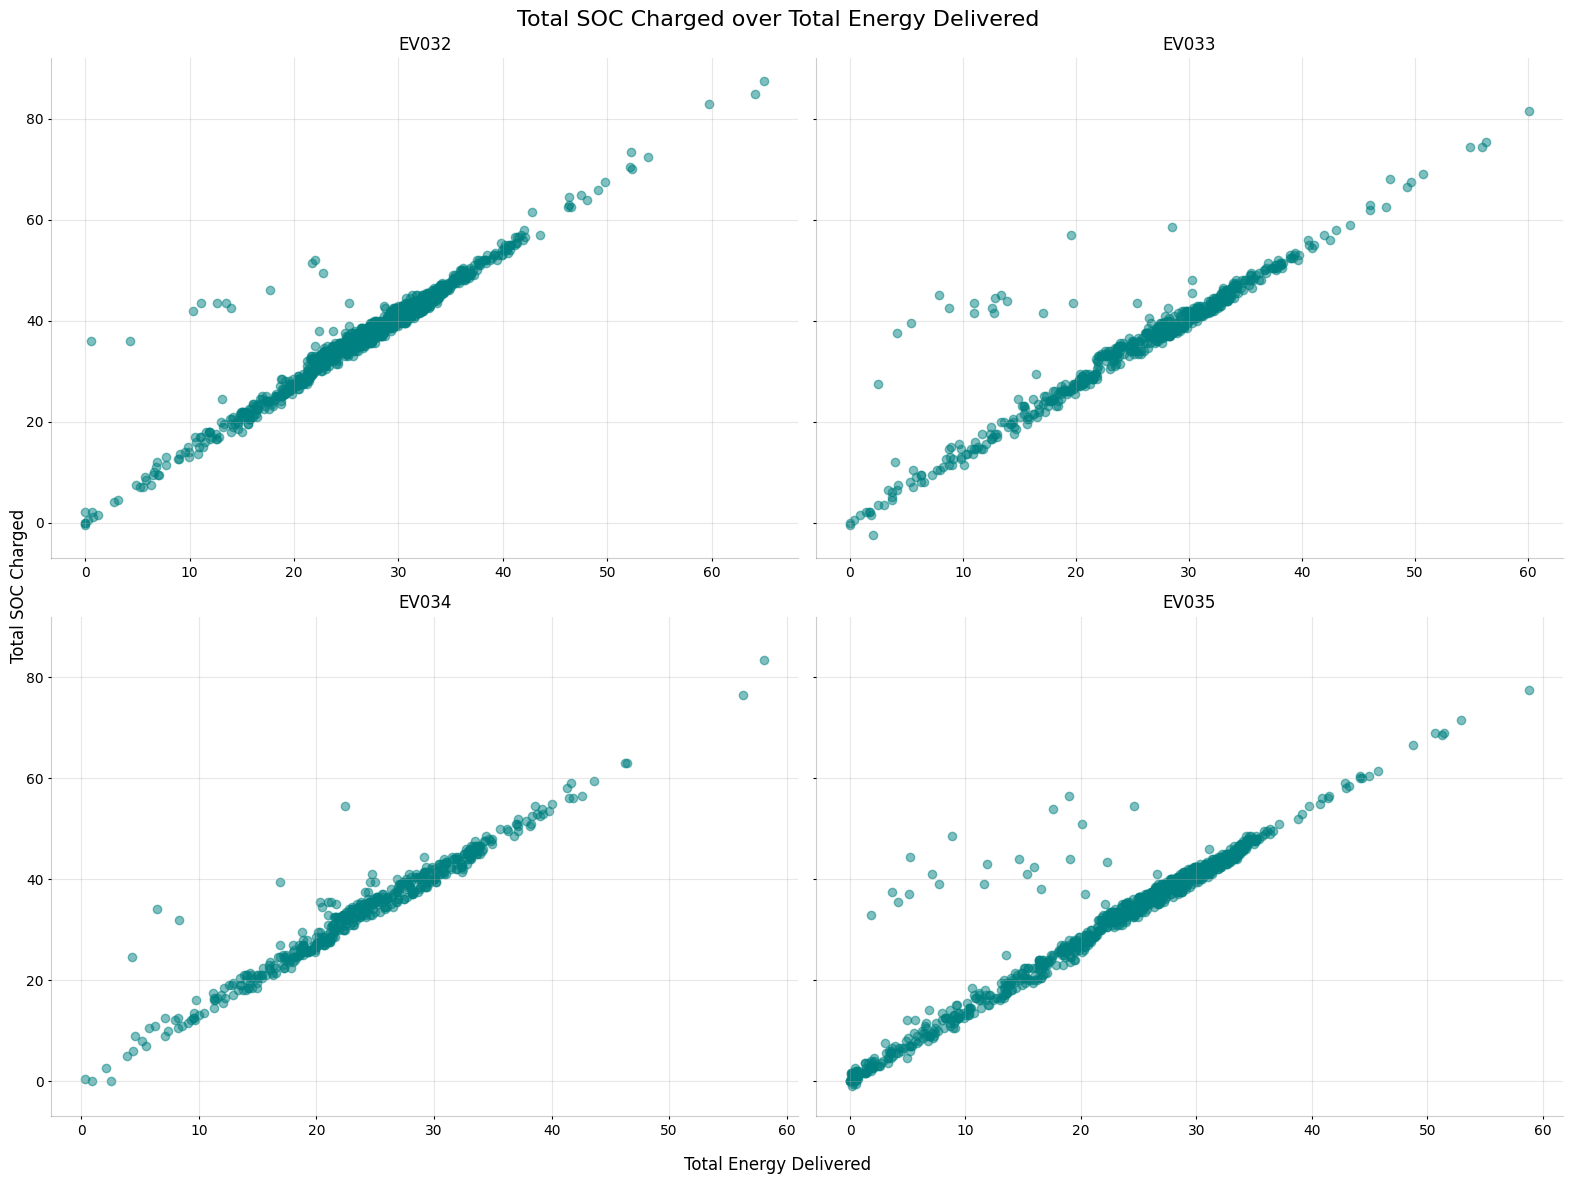

In [105]:
VehicleID = ChargingDF['Vehicle ID'].unique()[4:8]

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes = axes.flatten()

for i, VehicleID in enumerate(VehicleID):
    ChargingDFPlot = ChargingDF[ChargingDF['Vehicle ID'] == VehicleID] \
        .sort_values(by='Total Energy Delivered')
    ax = axes[i]
    ax.scatter(ChargingDFPlot['Total Energy Delivered'],
         ChargingDFPlot['Total SOC Charged'],
         color='teal',
         label=f'Vehicles {VehicleID}',
         alpha=0.5)
    ax.set_title(f'{VehicleID}')
    ax.grid(True, alpha=0.3)
    if i >= 4:
        ax.set_label('Local Trip End Time')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color((0, 0, 0, 0.2))
    ax.spines['bottom'].set_color((0, 0, 0, 0.2))

    ax.tick_params(axis='both', which='both', length=2)


fig.suptitle('Total SOC Charged over Total Energy Delivered', fontsize='16')
fig.supxlabel('Total Energy Delivered')
fig.supylabel('Total SOC Charged')
plt.tight_layout()
plt.show()

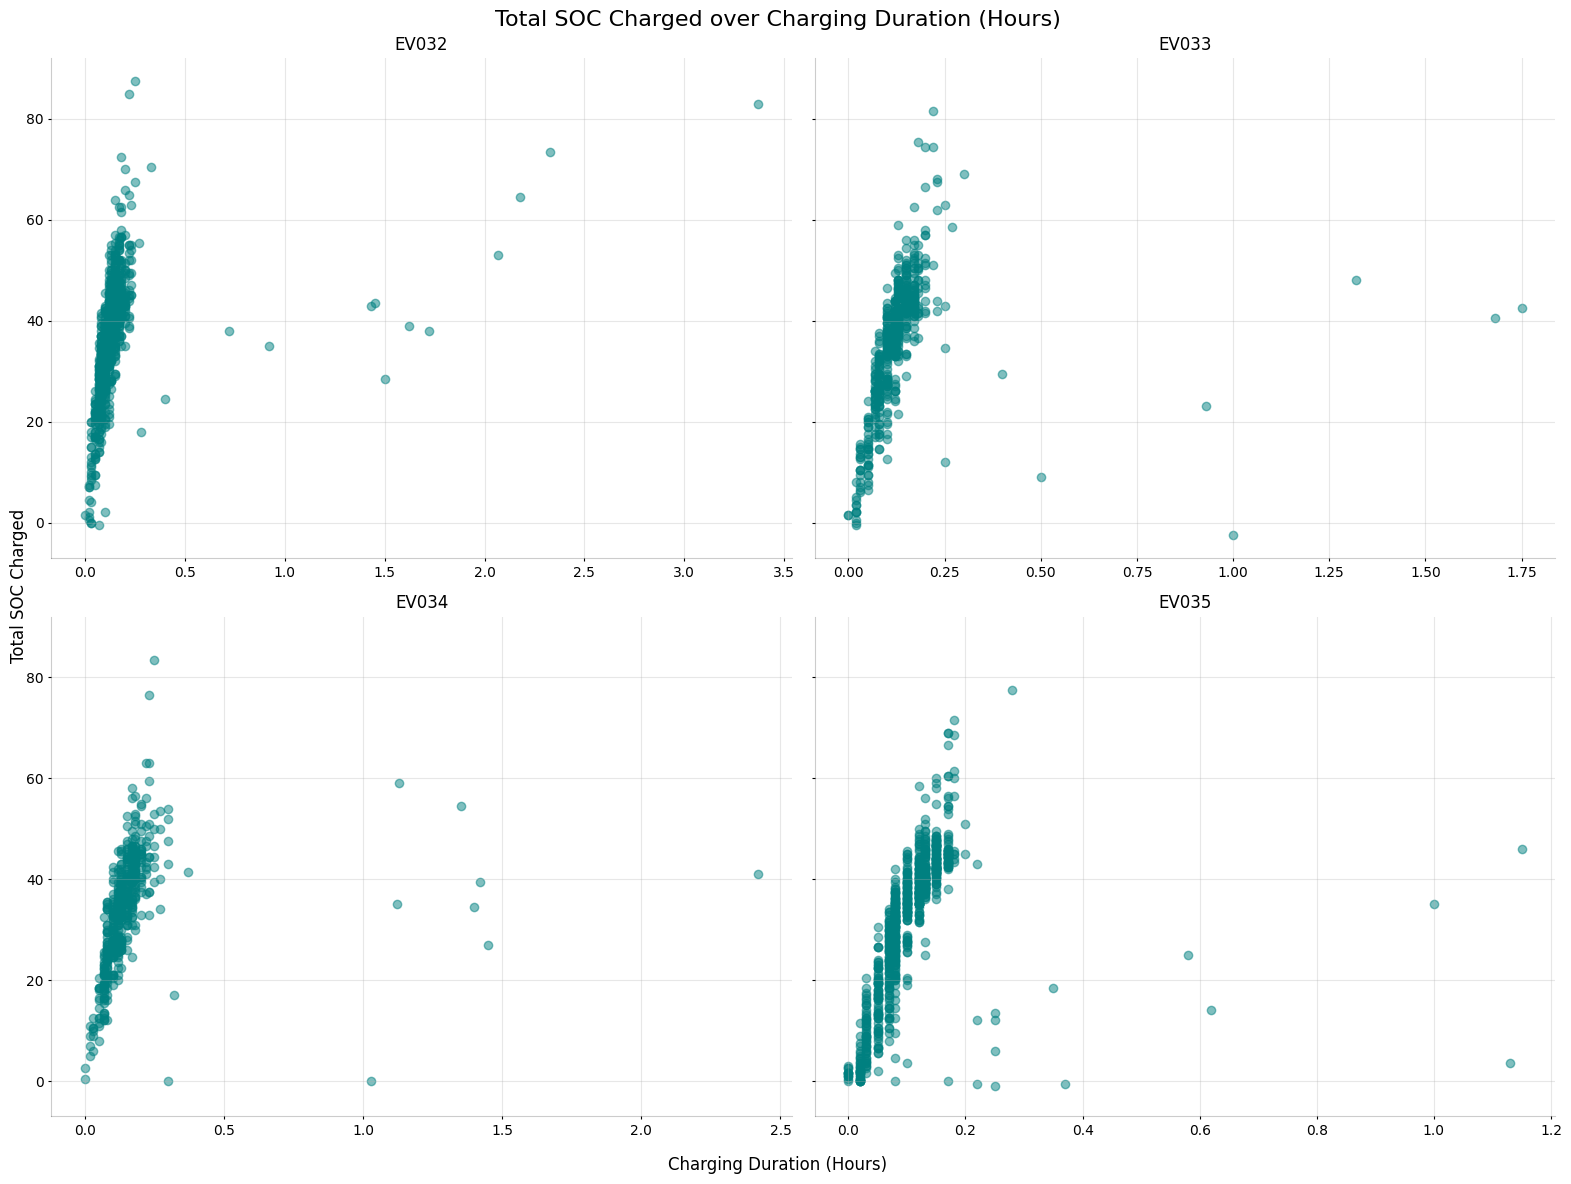

In [106]:
VehicleID = ChargingDF['Vehicle ID'].unique()[4:8]

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes = axes.flatten()

for i, VehicleID in enumerate(VehicleID):
    ChargingDFPlot = ChargingDF[ChargingDF['Vehicle ID'] == VehicleID] \
        .sort_values(by='Charging Duration (Hours)')
    ax = axes[i]
    ax.scatter(ChargingDFPlot['Charging Duration (Hours)'],
         ChargingDFPlot['Total SOC Charged'],
         color='teal',
         label=f'Vehicles {VehicleID}',
         alpha=0.5)
    ax.set_title(f'{VehicleID}')
    ax.grid(True, alpha=0.3)
    if i >= 4:
        ax.set_label('Local Trip End Time')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color((0, 0, 0, 0.2))
    ax.spines['bottom'].set_color((0, 0, 0, 0.2))

    ax.tick_params(axis='both', which='both', length=2)


fig.suptitle('Total SOC Charged over Charging Duration (Hours)', fontsize='16')
fig.supxlabel('Charging Duration (Hours)')
fig.supylabel('Total SOC Charged')
plt.tight_layout()
plt.show()

Removing outliers from the datasets.

Charging Data

In [16]:
NumericalColumnsC = ['Starting SOC', 'Ending SOC', 'Total Energy Delivered',
                     'Average Power', 'Max Power', 'Charging Duration (Hours)',
                      'Total SOC Charged']

Q1 = ChargingDF[NumericalColumnsC].quantile(0.25)
Q3 = ChargingDF[NumericalColumnsC].quantile(0.75)
InterQuartileRange = Q3 - Q1


LowerBound = Q1 - 0.5 * InterQuartileRange
UpperBound = Q3 - 0.5 * InterQuartileRange

FilteredChargingDF = ChargingDF[
    ((ChargingDF[NumericalColumnsC] >= LowerBound) &
      (ChargingDF[NumericalColumnsC] <= UpperBound)).any(axis=1)
]

print(f"Number of Rows before filtering: {len(ChargingDF)}")
print(f"Number of Rows after IQR filtering: {len(FilteredChargingDF)}")

Number of Rows before filtering: 6296
Number of Rows after IQR filtering: 5716


In [17]:
ChargingDF = FilteredChargingDF.copy()

In [18]:
round(ChargingDF[NumericalColumnsC].describe(), 2)

,Starting SOC,Ending SOC,Total Energy Delivered,Average Power,Max Power,Charging Duration (Hours),Total SOC Charged
count,5716.00,5716.00,5716.00,5716.00,5716.00,5716.00,5716.00
mean,59.59,93.19,24.06,232.52,306.17,0.12,33.60
std,11.67,9.56,8.82,66.63,66.83,0.11,11.69
min,5.00,35.00,0.00,-16.56,-16.36,0.00,-2.50
25%,53.00,90.50,19.29,198.00,275.19,0.08,27.00
50%,57.50,97.00,24.56,240.12,322.80,0.12,35.00
75%,66.00,100.00,30.53,280.39,355.90,0.15,42.00
max,100.00,100.00,65.03,367.30,382.24,2.42,87.50


Vehicle Data

In [19]:
NumericalColumnsT = ['Initial SOC', 'Final SOC', 'SOC Used',
                     'Total Energy Consumption','Total Distance',
                     'Average Ambient Temperature', 'Energy Efficiency',
                     'Trip Duration (Hours)']

Q1 = VehicleDF[NumericalColumnsT].quantile(0.25)
Q3 = VehicleDF[NumericalColumnsT].quantile(0.75)
InterQuartileRange = Q3 - Q1


LowerBound = Q1 - 0.5 * InterQuartileRange
UpperBound = Q3 - 0.5 * InterQuartileRange


FilteredVehicleDF = VehicleDF[
    ((VehicleDF[NumericalColumnsT] >= LowerBound) &
      (VehicleDF[NumericalColumnsT] <= UpperBound)).any(axis=1)
]

print(f"Number of Rows before filtering: {len(VehicleDF)}")
print(f"Number of Rows after IQR filtering: {len(FilteredVehicleDF)}")

Number of Rows before filtering: 8009
Number of Rows after IQR filtering: 7996


In [20]:
VehicleDF = FilteredVehicleDF.copy()

In [21]:
round(VehicleDF[NumericalColumnsT].describe(), 2)

,Initial SOC,Final SOC,SOC Used,Total Energy Consumption,Total Distance,Average Ambient Temperature,Energy Efficiency,Trip Duration (Hours)
count,7996.00,7996.00,7996.00,7996.00,7996.00,7996.00,6863.00,7996.00
mean,86.38,76.14,18.05,55.48,22.41,70.22,3.16,3.22
std,17.23,20.05,23.06,85.05,32.83,14.13,10.05,4.59
min,0.00,0.00,-40.50,0.00,0.00,7.25,-44.81,0.02
25%,80.50,59.49,0.33,1.31,0.15,61.55,0.54,0.40
50%,93.00,81.10,5.09,23.35,11.41,71.26,0.95,1.23
75%,98.91,93.58,35.00,69.86,30.87,79.16,2.85,3.83
max,100.00,100.00,187.84,801.24,181.77,108.68,425.81,24.15


### Data Preparation

In [22]:
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer


TargetT = ['SOC Used']

TargetC = ['Total SOC Charged']


ScalerTrip = MinMaxScaler()
VehicleDF[NumericalColumnsT] = ScalerTrip.fit_transform(VehicleDF[NumericalColumnsT])
VehicleDF[TargetT] = ScalerTrip.fit_transform(VehicleDF[TargetT])

ScalerCharge = MinMaxScaler()
ChargingDF[NumericalColumnsC] = ScalerCharge.fit_transform(ChargingDF[NumericalColumnsC])
ChargingDF[TargetC] = ScalerCharge.fit_transform(ChargingDF[TargetC])


In [23]:
print("Vehicle DF Null Values after normalizing: ", VehicleDF.isnull().sum())
VehicleDF.dropna(axis=0, inplace=True)

Vehicle DF Null Values after normalizing:  Vehicle ID                        0
Local Trip End Time               0
Initial SOC                       0
Final SOC                         0
SOC Used                          0
Total Energy Consumption          0
Total Distance                    0
Average Ambient Temperature       0
Energy Efficiency              1133
Trip Duration (Hours)             0
dtype: int64


In [24]:
round(VehicleDF.describe(), 2)

,Local Trip End Time,Initial SOC,Final SOC,SOC Used,Total Energy Consumption,Total Distance,Average Ambient Temperature,Energy Efficiency,Trip Duration (Hours)
count,6863,6863.00,6863.00,6863.00,6863.00,6863.00,6863.00,6863.00,6863.00
mean,2020-10-19 01:44:14.993443072,0.87,0.75,0.27,0.08,0.14,0.62,0.10,0.15
min,2018-01-02 07:21:00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00
25%,2018-07-13 07:00:00,0.81,0.58,0.18,0.00,0.00,0.51,0.10,0.03
50%,2022-04-16 23:09:00,0.94,0.79,0.23,0.04,0.08,0.62,0.10,0.07
75%,2022-11-14 10:37:30,0.99,0.93,0.34,0.11,0.20,0.71,0.10,0.19
max,2023-03-27 23:59:00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
std,NaN,0.17,0.20,0.10,0.11,0.19,0.15,0.02,0.20


In [25]:
round(ChargingDF.describe(), 2)

,Local Charge End Time,Starting SOC,Ending SOC,Total Energy Delivered,Average Power,Max Power,Charging Duration (Hours),Total SOC Charged
count,5716,5716.00,5716.00,5716.00,5716.00,5716.00,5716.00,5716.00
mean,2018-04-18 11:38:48.705388288,0.57,0.90,0.37,0.65,0.81,0.05,0.40
min,2017-09-01 08:09:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2018-02-15 09:19:30,0.51,0.85,0.30,0.56,0.73,0.03,0.33
50%,2018-04-16 15:47:30,0.55,0.95,0.38,0.67,0.85,0.05,0.42
75%,2018-06-24 10:44:30,0.64,1.00,0.47,0.77,0.93,0.06,0.49
max,2018-08-13 19:30:00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
std,NaN,0.12,0.15,0.14,0.17,0.17,0.05,0.13


In [26]:
Encoder = LabelBinarizer()

VEncoded = Encoder.fit_transform(VehicleDF['Vehicle ID'])

EncodedTVID = [f"Vehicle_{VClass}" for VClass in Encoder.classes_]
EncodedTDF = pd.DataFrame(VEncoded, columns=EncodedTVID)
VehicleDF = pd.concat([VehicleDF.reset_index(drop=True),
                       EncodedTDF.reset_index(drop=True)],
                       axis=1)

CEncoded = Encoder.fit_transform(ChargingDF['Vehicle ID'])

EncodedCVID = [f"Vehicle_{VClass}" for VClass in Encoder.classes_]
EncodedCDF = pd.DataFrame(CEncoded, columns=EncodedCVID)
ChargingDF = pd.concat([ChargingDF.reset_index(drop=True),
                        EncodedCDF.reset_index(drop=True)],
                        axis=1)

In [27]:
def CreateSequences(Data, VehicleIDCol, EncodedVIDCols, Features, Target, SequenceLength, DTCol):
    """
    Create sequences of Features & Targets grouped by Vehicle ID.

    Parameters:
    - Data: DataFrame containing the data.
    - VehicleCol: Column name for Vehicle IDs.
    - EncodedVIDCols: List one-hot encoded Vehicle ID column names.
    - Features: List of feature column names.
    - Target: Target column name.
    - n: number of time steps in each sequence.

    Returns:
    - X: Numpy array of input sequences (shape: NumSampels, SequenceLength, NumFeatures)
    - y: Numpy array of target values (shape: NumSamples, 1)
    """

    X, y = [], []

    Data = Data.reset_index(drop=True)

    Grouped  = Data.groupby(VehicleIDCol)
    
    for _,Group in Grouped:

        Group = Group.sort_values(by=DTCol)

        for i in range(len(Group) - SequenceLength):
            FeaturesCols = Features + EncodedVIDCols
            X.append(Group[FeaturesCols].iloc[i:i+SequenceLength].values)
            y.append(Group[Target].iloc[i+SequenceLength].values)

    return np.array(X), np.array(y)

SequenceLength = 5

FeaturesT = ['Local Trip End Time',
             'Initial SOC',
             'Final SOC', 
             'Total Energy Consumption', 
             'Total Distance', 
             'Average Ambient Temperature',
             'Energy Efficiency',
             'Trip Duration (Hours)']

FeaturesC = ['Local Charge End Time',
             'Starting SOC', 
             'Ending SOC', 
             'Total Energy Delivered', 
             'Average Power', 
             'Max Power',
             'Charging Duration (Hours)']

XTrip, yTrip = CreateSequences(
    Data=VehicleDF,
    VehicleIDCol='Vehicle ID',
    Features=FeaturesT,
    EncodedVIDCols=EncodedTVID,
    Target=TargetT,
    SequenceLength=SequenceLength,
    DTCol='Local Trip End Time'
)

XCharge, yCharge = CreateSequences(
    Data=ChargingDF,
    VehicleIDCol='Vehicle ID',
    EncodedVIDCols=EncodedCVID,
    Features=FeaturesC,
    Target=TargetC,
    SequenceLength=SequenceLength,
    DTCol='Local Charge End Time'
)

print("XTrip shape: ", XTrip.shape)
print("yTrip shape: ", yTrip.shape)

print("\nXCharge shape: ", XCharge.shape)
print("yCharge shape: ", yCharge.shape)

XTrip shape:  (6728, 5, 35)
yTrip shape:  (6728, 1)

XCharge shape:  (5676, 5, 15)
yCharge shape:  (5676, 1)


In [28]:
def DataPrep(X1, X2, y1, y2, TestSize=0.3, RandomState=301):
    """This function splits the datasets provided into 
    Train, Test and Validation sets that the model can use.
    
    Parameters:
    X1: First set of data containing the feature values.
    X2: Second set of data containing the feature values.
    y1: First set of data containing the target values.
    X2: Second set of data containing the Target values.
    TestSize: Percentage of data to be separated for testing 0.3 by default.
    RandomState: State of the model for replication if required, 301 by default.
    """

    # Acquiring the value of the minimum number of samples present
    MinSamples = min(len(X1), len(X2), len(y1), len(y2))

    # Fetching the min samples from each set for equal shape
    X1, y1 = X1[:MinSamples], y1[:MinSamples]
    X2, y2 = X2[:MinSamples], y2[:MinSamples]

    # Expanding dimensions for acceptable model shape
    y1 = np.expand_dims(y1, axis=-1)
    y2 = np.expand_dims(y2, axis=-1)
    
    # Splitting data
    X1Train, X1Temp, y1Train, y1Temp = train_test_split(X1, y1,
                                                    test_size=TestSize,
                                                    random_state=RandomState)
    
    X2Train, X2Temp, y2Train, y2Temp = train_test_split(X2, y2,
                                                    test_size=TestSize,
                                                    random_state=RandomState)
    
    # Splitting further into test and validation sets
    X1Val, X1Test, y1Val, y1Test = train_test_split(X1Temp, y1Temp,
                                                    test_size=0.5,
                                                    random_state=RandomState)
    
    X2Val, X2Test, y2Val, y2Test = train_test_split(X2Temp, y2Temp,
                                                    test_size=0.5,
                                                    random_state=RandomState)
    
    return (X1Train, X1Val, X1Test, y1Train, y1Val, y1Test), \
        (X2Train, X2Val, X2Test, y2Train, y2Val, y2Test)


(TripTrain, TripVal, TripTest, SOCTrain, SOCVal, SOCTest), \
(ChargeTrain, ChargeVal, ChargeTest, AnomalyTrain, AnomalyVal, AnomalyTest) = DataPrep(
    XTrip, XCharge, yTrip, yCharge
    )

In [29]:
print("TripTrain shape:", TripTrain.shape)
print("ChargeTrain shape:", ChargeTrain.shape)
print("SOCTrain shape:", SOCTrain.shape)
print("AnomalyTrain shape:", AnomalyTrain.shape)

print("\nTripVal shape:", TripVal.shape)
print("ChargeVal shape:", ChargeVal.shape)
print("SOCVal shape:", SOCVal.shape)
print("AnomalyVal shape:", AnomalyVal.shape)

TripTrain shape: (3973, 5, 35)
ChargeTrain shape: (3973, 5, 15)
SOCTrain shape: (3973, 1, 1)
AnomalyTrain shape: (3973, 1, 1)

TripVal shape: (851, 5, 35)
ChargeVal shape: (851, 5, 15)
SOCVal shape: (851, 1, 1)
AnomalyVal shape: (851, 1, 1)


#### Model Training

In [30]:
from keras.losses import Huber
from keras.regularizers import l2

Optim = Adam(learning_rate=0.0001)

FCModel = Sequential()

FCModel.add(Input(shape=TripTrain.shape[1:]))

FCModel.add(LSTM(64, return_sequences=True, 
                 recurrent_dropout=0.2))

FCModel.add(BatchNormalization())

FCModel.add(Dropout(0.1))

FCModel.add(Dense(32, activation='relu',
                  kernel_regularizer=l2(0.001)))

FCModel.add(LSTM(32,
                 return_sequences=False,
                 recurrent_dropout=0.1,
                 dropout=0.05))

FCModel.add(Dense(16, activation='relu'))

FCModel.add(Dense(1, activation='linear'))

FCModel.compile(optimizer=Optim,
                metrics=['mse', 'mae'],
                loss=Huber(delta=0.5))

FCModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,801 (143.75 KB)

 Trainable params: 36,673 (143.25 KB)

 Non-trainable params: 128 (512.00 B)

In [31]:
FCHistory = FCModel.fit(TripTrain,
                        SOCTrain,
                        validation_data=(TripVal, SOCVal),
                        batch_size=64,
                        epochs=10,
                        verbose=1)

ValueError: Invalid dtype: object

In [ ]:
FCHistory = FCHistory.history

plt.figure(figsize=(12, 6))


plt.subplot(1, 2 ,1)
plt.plot(FCHistory['loss'], label='Training Loss')
plt.plot(FCHistory['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(FCHistory['mae'], label='Training MAE')
plt.plot(FCHistory['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Mean Absolute Error (MAE) over Epoch')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
SOCPreds = FCModel.predict(TripTest)

SOCPreds = SOCPreds.flatten()
SOCTest = SOCTest.flatten()

plt.figure(figsize=(12,4))

plt.plot(SOCTest, label='True SOC Values', alpha=0.3, color='blue')
plt.plot(SOCPreds, label='Predicted SOC Values', alpha=0.7, color='orange')

plt.title('SOC Predictions Vs True Values')
plt.xlabel('Sample Index')
plt.ylabel('SOC Value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

SOCMse = mean_squared_error(SOCTest, SOCPreds)
SOCMae = mean_absolute_error(SOCTest, SOCPreds)
SOCRmse = np.sqrt(SOCMse)
SOCr2 = r2_score(SOCTest, SOCPreds)

print(f"Mean Absolute Error (MAE): {round(SOCMae, 3)}")
print(f"Mean Squared Error (MSE): {round(SOCMse, 3)}")
print(f"Root Mean Squared Error: {round(SOCRmse, 3)}")
print(f"R-Squared (r2): {round(SOCr2, 3)}")

Residuals = SOCTest - SOCPreds

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(SOCPreds, Residuals, alpha=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('Residual Plot')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')

axes[1].scatter(SOCTest, SOCPreds, alpha=0.5)
axes[1].plot([min(SOCTest), max(SOCTest)], [min(SOCPreds), max(SOCPreds)], 'r--')
axes[1].set_title('Predictions Vs. Actuals')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')

axes[2].hist(Residuals, bins=30, alpha=0.75)
axes[2].set_title('Error Distribution')
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
Optim2 = Adam(learning_rate=0.0001)

AnomalyModel = Sequential()

AnomalyModel.add(Input(shape=ChargeTrain.shape[1:]))

AnomalyModel.add(Dense(128, activation='relu'))
AnomalyModel.add(Dense(64, activation='relu'))
AnomalyModel.add(Dense(32, activation='relu'))

AnomalyModel.add(Dense(16, activation='relu'))

AnomalyModel.add(Dense(32, activation='relu'))
AnomalyModel.add(Dense(64, activation='relu'))
AnomalyModel.add(Dense(128, activation='relu'))

AnomalyModel.add(Dense(ChargeTrain.shape[1], activation='relu'))

AnomalyModel.compile(
    optimizer=Optim2,
    loss=Huber(delta=0.10),
    metrics=['mse', 'mae']
)

AnomalyModel.summary()

In [ ]:
import tensorflow as tf

tf.config.experimental_run_functions_eagerly(True)

AnomalyHistory = AnomalyModel.fit(
    ChargeTrain,
    AnomalyTrain,
    batch_size=32,
    epochs=25,
    validation_data=(ChargeVal, AnomalyVal)
)

In [ ]:
AnomalyHistory = AnomalyHistory.history

plt.figure(figsize=(12, 6))


plt.subplot(1, 2 ,1)
plt.plot(AnomalyHistory['loss'], label='Training Loss')
plt.plot(AnomalyHistory['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(AnomalyHistory['mae'], label='Training MAE')
plt.plot(AnomalyHistory['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Mean Absolute Error (MAE) over Epoch')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
TripFeatures = TripTrain.shape[2]
ChargeFeatures = ChargeTrain.shape[2]

TripInput = Input(shape=(SequenceLength, TripFeatures), name='TripInput')
ChargeInput = Input(shape=(SequenceLength, ChargeFeatures), name='ChargeInput')


TripDense = Dense(64, activation='relu')(TripInput)
ChargeDense = Dense(64, activation='relu')(ChargeInput)

Shared = concatenate([TripDense, ChargeDense])
SharedDense = Dense(128, activation='relu')(Shared)

LSTMLayer = LSTM(64, return_sequences=True)(SharedDense)
LSTMOutput = Dense(1, activation='linear', name='SOCOutput')(LSTMLayer)

Encoder = LSTM(64, activation='relu', return_sequences=False)(SharedDense)
Repeat = RepeatVector(SequenceLength)(Encoder)
Decoder = LSTM(64, activation='relu', return_sequences=True)(Repeat)
AutoEncoderOutput = TimeDistributed(Dense(ChargeFeatures), name='AnomalyOutput')(Decoder)

CombinedModel =  Model(inputs=[TripInput, ChargeInput],
              outputs=[LSTMOutput, AutoEncoderOutput])

Optim3 = Adam(learning_rate=0.0001)

CombinedModel.compile(
    optimizer = Optim3,
    loss = {
        'SOCOutput': 'mse',
        'AnomalyOutput': 'mse',
    },
    metrics = {
        'SOCOutput': 'mae',
        'AnomalyOutput': 'mae'
    }
)

CombinedModel.summary()

In [ ]:
History = CombinedModel.fit(
    x={"TripInput": TripTrain, "ChargeInput": ChargeTrain},
    y={"SOCOutput": SOCTrain, "AnomalyOutput": AnomalyTrain},
    validation_data=(
        {"TripInput": TripVal, "ChargeInput": ChargeVal},
        {"SOCOutput": SOCVal, "AnomalyOutput": AnomalyVal}
    ),
    batch_size=64,
    epochs=50,
    verbose=1
)

In [ ]:
history = History.history


Loss = History.history['loss']
ValLoss = History.history['val_loss']
SOCMae = History.history['SOCOutput_mae']
ValSOCMae = History.history['val_SOCOutput_mae']
AnomalyMae = History.history['AnomalyOutput_mae']
ValAnomalyMae = History.history['val_AnomalyOutput_mae']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2 ,1)
plt.plot(Loss, label='Training Loss')
plt.plot(ValLoss, label='Validation Loss', linestyle='--')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
axes[0].plot(SOCMae, label='Training SOC MAE', linestyle='-', color='blue')
axes[0].plot(ValSOCMae, label='Validation SOC MAE', linestyle='--', color='blue')
axes[0].set_title('SOCOutput MAE During Training')
axes[0].set_ylabel('Mean Absolute Error (MAE)')
axes[0].legend()
axes[0].grid()


axes[1].plot(AnomalyMae, label='Training Anomaly MAE', linestyle='-', color='orange')
axes[1].plot(ValAnomalyMae, label='Validation Anomaly MAE', linestyle='--', color='orange')
axes[1].set_title('Anomaly MAE During Training')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
Preds = CombinedModel.predict(
    {"TripInput": TripTest,
     "ChargeInput": ChargeTest}
)

SOCPreds = Preds[0]
AnomalyPreds = Preds[1]

plt.figure(figsize=(12, 6))
plt.plot(np.sort(SOCTest.reshape(-1)), label='True SOC Values', alpha=0.7)
plt.plot(np.sort(SOCPreds.reshape(-1)), label='Predicted SOC Values', alpha=0.7)
plt.title('SOC Predictions Vs True Values')
plt.xlabel('Sample Index')
plt.ylabel('State of Charge (SOC)')
plt.legend()
plt.grid()
plt.show()